In [1]:
from scipy.ndimage import gaussian_filter1d

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#For plotting purposes
def Scale(x,y):
    """Scales x such that the max(x) = max(y)"""
    return (max(y)/max(x))*np.array(x)

In [25]:
def XSECReader(path, Data= "Pandas"):
    """
    Input:
    path: Location of file you want to input - type = .xsec or any tab_delim file
    Data: "Pandas" (default is Pandas), if anything else: will return two outputs, "lambda" and "sigma". - dtype = str
    
    Output: 
    XSEC: Data outputted in pandas DataFrame - dtype = DataFrame 
    Lambda, Sigma: if Data != "Pandas", returns "lambda" and "sigma" upacked - dtypes = np.array
    """
    
    if Data == "Pandas":
        XSEC = pd.read_table(path,delim_whitespace=True,names=["lambda","sigma"])
        return XSEC
    else:
        Lambda, Sigma = np.loadtxt(path, unpack = True)
        return Lambda, Sigma
    

def Smoother(Data_Lambda, Data_Sigma, alpha=1000, scalefactor=1):
    
    """
    Input: 
    Data_Lambda: Input cross section "lambda" (must have equal incrementations)- dtype = np.array
    Data_Sigma: Input cross section "sigma" - dtype = np.array
    alpha: Value of alpha filtering parameter, default = 1000 - dtype = float
    scalefactor: Linear multiplicative scale factor for resulting curve, default is 1 - dtype = float
    
    Output: 
    Gaussian filtered cross section 
    """
    
    dl = Data_Lambda[1] - Data_Lambda[0] #Finds distance between lambda data points
    
    rang=alpha/dl  
    
    Filtered = gaussian_filter1d(Data_Sigma, rang)*10**(scalefactor) #Performs gaussian smoothing
    
    return Filtered #Returns Filtered curve cross section values

def Diff(x, fx, sampling_frequency = 1):
    """
    Input: 
    x, fx: Input curve x and fx values - dtypes = np.array
    sampling frequency: number of data points between gradient pair - dtype = int
    
    Output:
    x: truncated x array accounting for lost terms - dtype = np.array
    f_prime: 1st differential f_prime(x) points - dtype = np.array
    """
    
    dx = x[sampling_frequency] - x[0] 
    f_prime = []
    
    for i in range(len(fx)-sampling_frequency):
        f_prime.append((fx[i+sampling_frequency]-fx[i])/dx)
        
    x = x[:(len(f_prime)-len(x))]
    return x, f_prime

def CountRoots(x, function, positions = False, ThreshFunc = 0, Thresh = 0):
    """
    Input: 
    x: x points - dtype = np.array
    function: (gradient function) f'(x) points - dtype = np.array
    positions: return location of roots in the x array (point before crossover), default = False - dtype = boolean
    ThreshFunc: Integral of "function", default = 0 - dtype = np.array
    Thresh: If ThreshFunc < Thresh, if root found, not counted, else, counted, default = 0 - dtype = float  
    
    Output:
    Counter: Number of roots in the function - dtype = int
    Positions: if positions != False Location of all roots - dtype = list 
    """
    Counter = 0
    
    if Thresh == 0:
        if positions == False:
            for i in range(len(function)-1):
                if np.sign(function[i]) != np.sign(function[i+1]):
                    Counter += 1
            return Counter
        else:
            Positions = []
            for i in range(len(function)-1):
                if np.sign(function[i]) != np.sign(function[i+1]):
                    Counter += 1
                    Positions.append(x[i]) 
            return Counter, Positions
        
    else:
        if positions == False:
            for i in range(len(function)-1):
                if np.sign(function[i]) != np.sign(function[i+1]) and ThreshFunc[i] > Thresh:
                    Counter += 1
            return Counter
        else:
            Positions = []
            for i in range(len(function)-1):
                if np.sign(function[i]) != np.sign(function[i+1]) and  ThreshFunc[i] > Thresh:
                    Counter += 1
                    Positions.append(x[i]) 
            return Counter, Positions

def AlphaFinder(Alpha_Range, Lambda, Sigma, Num_Turn_Points=1, sampling_frequency = [0.01, 0.01], scalefactor_ = 18, Thresh_ = 0, positions = False):
    """
        Input: 
        Alpha Range: range of Alphas to test - dtype = np.array
        Lambda: lambda values for input signal - dtype = np.array
        Sigma: sigma values for input signal - dtype = np.array
        Num_Turn_Points: Number of turning points in expected cross section, found by visual inspection - dtype = Float
        sampling_frequency: sampling frequency as a percentage (of input signal length [between 0 - 1]) - dtype = list
        scalefactor_: Linear multiplicative scale factor for resulting curve, default is 1 - dtype = float
        Thresh_: Threshold value for function if root located in region where function < Thresh, root not counted. 
        
        Output:
        Optimum_Alpha: Alpha which satisfies test parameters
    """
    #Defining Test Parameters and Sampling Frequencies
    
    Test_Parameters = [Num_Turn_Points, Num_Turn_Points+1] # Turning point tests
    
    # Sampling frequency transformed from percentage to int
    Samp_1 = int(round(len(Lambda)*sampling_frequency[0],0)) 
    Samp_2 = int(round(len(Lambda)*sampling_frequency[1],0))
    
    for i in Alpha_Range:
        print(f"Curent Alpha = {i}")
        Filtered = Smoother(Lambda, Sigma, i, scalefactor=scalefactor_)
        
        # differentiation
        x_1, f_prime_1 = Diff(Lambda, Filtered, Samp_1)
        x_2, f_prime_2 = Diff(x_1, f_prime_1, Samp_2)
        
        Roots_1 = CountRoots(x_1,f_prime_1, positions = False, ThreshFunc=Filtered, Thresh = Thresh_)
        Roots_2 = CountRoots(x_2,f_prime_2, positions = False, ThreshFunc=Filtered, Thresh = Thresh_)
        
        if Roots_1 == Test_Parameters[0] and Roots_2 == Test_Parameters[1]:
            break
            
    Optimum_Alpha = i   
    print(f"Root No First Der: {Roots_1}, Root No Second Der: {Roots_2}") 
    return Optimum_Alpha        

In [52]:
Lambda,Sigma = XSECReader("XSEC_OH_X_1_100K.xsec", Data="Numpy")

Alpha_Range = [*np.linspace(1000,4000,10)]

Optimum_Alpha_12Sigma = AlphaFinder(Alpha_Range, Lambda, Sigma,sampling_frequency=[0.01,0.01], Thresh_=0.5e-23, positions=True)

Filt = Smoother(Lambda, Sigma, alpha=Optimum_Alpha_12Sigma, scalefactor=23)

Diff1_Lambda, Diff1_Sigma = Diff(Lambda, Filt, sampling_frequency = 2400)
Diff2_Lambda, Diff2_Sigma = Diff(Diff1_Lambda, Diff1_Sigma, sampling_frequency = 2400)

Curent Alpha = 1000.0
Curent Alpha = 1333.3333333333333
Curent Alpha = 1666.6666666666665
Curent Alpha = 2000.0
Curent Alpha = 2333.333333333333
Curent Alpha = 2666.6666666666665
Curent Alpha = 3000.0
Curent Alpha = 3333.333333333333
Curent Alpha = 3666.6666666666665
Curent Alpha = 4000.0
Root No First Der: 1, Root No Second Der: 7


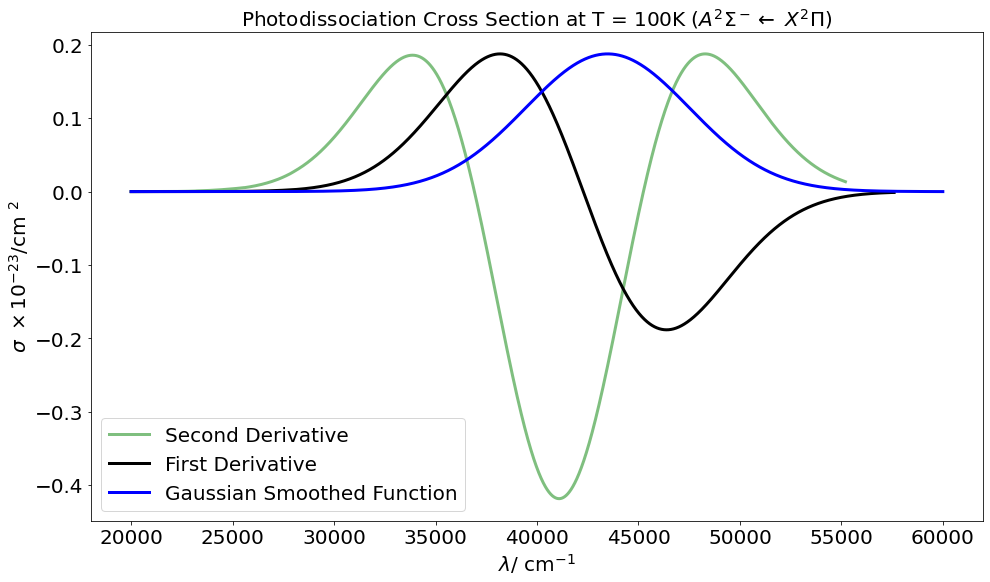

In [53]:
plt.figure(figsize = (16,9))

#plt.plot(Lambda,np.array(Sigma)*1e18, "k-",linewidth =3, label = "Raw Signal")

plt.plot(Diff2_Lambda,Scale(Diff2_Sigma, Filt),"g-",linewidth = 3, alpha = 0.5, label = "Second Derivative")
plt.plot(Diff1_Lambda,Scale(Diff1_Sigma, Filt),"k-",linewidth = 3, label = "First Derivative")

#plt.text(min(Diff1_Lambda), 1.5, f"Number of Roots - 1st = {CountRoots(Diff1_Lambda, Diff1_Sigma, positions=True)[0]}", fontsize = 15)
#plt.text(min(Diff1_Lambda), 2, f"Number of Roots - 2nd = {CountRoots(Diff2_Lambda, Diff2_Sigma, positions=True)[0]}", fontsize = 15)
#plt.text(min(Diff1_Lambda), -0.5, f"Root loc - 1st Diff: $\lambda$ = {CountRoots(Diff1_Lambda, Diff1_Sigma, positions=True)[1]}", fontsize = 15)

plt.plot(Lambda, Filt,"b-",linewidth = 3, label = "Gaussian Smoothed Function")
plt.title(r"Photodissociation Cross Section at T = 100K $(A^2\Sigma^-\leftarrow~X^2\Pi)$",fontsize = 20)
plt.xlabel(r"$\lambda$/ cm$^{-1}$",fontsize = 20)
plt.ylabel(r"$\sigma~\times 10^{-23}$/cm $^2$",fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc = "best", fontsize = 20)
plt.show()